In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mticker

font = 16
plt.rcParams.update({'font.size': 16})

## 0. Get substitution,indel and soft-clipping rate of Guppy reads

new logic, map to ref and pos by pos
- M/X
- insertion : 23M10I30M ->  one insertion at pos 23
- deletion:  23M10D -> 10 deletion from pos 23 to 33
- softclipping: 
-- insertion (mode 1)
-- softclipping (mode 2)
-- not track (mode 3)
- not align from ref pos 0:
-- deletion (mode 1, 3)
-- softclipping (mode 2)
- length is shorter than ref, but cigar not track 
-- deletion (mode 1, 3)
-- softclipping (mode 2)

In [2]:
ref_path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/ref-seq-8-32.fa'

ref = []
with open(ref_path) as file_in:
    for line in file_in:
        if line.startswith('>'):
            continue
        else:
            ref.append(line.strip())

ref[0]

'TACAGGACTACAGGGGACCGGAAACTACAACGCAGATTACAACCTCAGTTTTCCGGTCCCCTGTAGTCCTGTAA'

In [3]:
path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/guppy/'
sam_path = path + 'minimap2-8-32-cov100-final.sam'
read_path = path + 'guppy-mapped-cov100.string'

# path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/bonito-ssp/'
# sam_path = path + '200707_SSP_formatted-mapped-mn.sam'
# read_path = path + '200707_SSP_formatted.fasta'

# path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/bonito/'
# sam_path = path + '200707_ori_bonito_formatted-mapped-mn.sam'
# read_path = path + '200707_ori_bonito_formatted.fasta'

# path = '/Users/yan/Desktop/eurecom_code/data/motif/error-rate/guppy/'
# sam_path = path + 'guppy-mapped-mn.sam'
# read_path = path + '200707_ori_guppy.fasta'

In [4]:
read = []
cnt = 1
with open(read_path) as file_in:
    for line in file_in:
        read.append([str(cnt), line.strip()])
        cnt += 1

read = pd.DataFrame(read)
read = read.rename(columns={0: "read_id", 1: "read_seq"})
read.head(3)

,read_id,read_seq
0,1,TGTACTTCGTTCAGTTACGTATTGCTCATGGGAGTGGAAACGAAAC...
1,2,TTGCCTTCGTTCGGTTACGTATTGCTTACAGGACTACAGGGGACCG...
2,3,CTGTACTTCAGATTGCCTTGTTGTACTTCGTTCCAGTTACGTATTA...


In [5]:
## Load the sam file '.sam'
sam = pd.read_csv(sam_path)
sam['read_id'] = sam['read_id'].astype(str)
sam = pd.merge(sam, read, how='left', left_on=['read_id'], right_on=['read_id'])
sam['len'] = sam['read_seq'].str.len()
sam.head(3)

,read_id,pos,oligo,score,FLAG,oligo_id,MAPQ,CIGAR,NM,read_seq,len
0,1,193,>5PMotif_7MoSS5->3PMotif_30MoSS5,116,0,222,20,64M10S,NM:i:2,TGTACTTCGTTCAGTTACGTATTGCTCATGGGAGTGGAAACGAAAC...,290
1,2,27,>5PMotif_1MoSS5->3PMotif_31MoSS5,104,0,31,10,55M19S,NM:i:1,TTGCCTTCGTTCGGTTACGTATTGCTTACAGGACTACAGGGGACCG...,175
2,2,116,>5PMotif_7MoSS5->3PMotif_7MoSS5,116,0,199,21,58M16S,NM:i:0,TTGCCTTCGTTCGGTTACGTATTGCTTACAGGACTACAGGGGACCG...,175


In [6]:
ref_cnt = sam['oligo_id'].value_counts().rename_axis('unique_values').reset_index(name='counts')
print("the median coverage is " + str(ref_cnt['counts'].median()))
print("the mean coverage is " + str(ref_cnt['counts'].mean()))
sam = sam.groupby('read_id').head(1).reset_index(drop=True)
print('nb. of aligned reads: ' + str(len(sam)))
sam = sam[sam['len']>50]
print('nb. of aligned reads with good read length (>50bp): ' + str(len(sam)))

the median coverage is 24.0
the mean coverage is 30.046875
nb. of aligned reads: 6576
nb. of aligned reads with good read length (>50bp): 6576


In [7]:
mode = 3
def check_cigar_on_ref(s):
#     print(s)
    cigar = s['CIGAR']
    read_start = s['pos']
    read_seq = s['read_seq']
    ref_id = s['oligo_id']
    ref_seq = ref[ref_id - 1]

    read_pos = read_start - 1
    ref_pos = 0

    cigar_num = []
    cigar_char = []
    num = 0

    for i in cigar:
        if i.isdigit():
            num = num * 10 + int(i)
        else:
            cigar_num.append(num)
            cigar_char.append(i)
            num = 0

    res = ''
    for i in range(len(cigar_char)):
        if cigar_char[i] == 'S':
            res += ('S' * cigar_num[i])
            ref_pos += cigar_num[i]
        elif cigar_char[i] == 'M':
            for j in range(cigar_num[i]):
                if read_seq[read_pos] == ref_seq[ref_pos]:
                    res += 'M'
                else:
                    res += 'X'
                read_pos += 1
                ref_pos += 1
        elif cigar_char[i] == 'I':
            res += ('D' * cigar_num[i])
            ref_pos += cigar_num[i]
        elif cigar_char[i] == 'D':
            res += 'I'
            read_pos += cigar_num[i]

    return res

In [8]:
sam['flatten'] = sam.apply(check_cigar_on_ref, axis=1)
sam['len'] = sam['flatten'].str.len()
max_len = sam['len'].max()
flattened = sam['flatten'].tolist()
flattened[0]

'MMMMMMMMMMXMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMXMMMMMMMMMMMMMMMMMMMMMMSSSSSSSSSS'

In [9]:
max_len = 76
mis_rate = []
i_rate = []
d_rate = []
other_rate = []

for i in range(max_len):
    nb_m = 0
    nb_mis = 0
    nb_i = 0
    nb_d = 0
    nb_o = 0
    
    for j in range(len(flattened)):
        if i < len(flattened[j]):
            if flattened[j][i] == 'M':
                nb_m += 1
            elif flattened[j][i] == 'I':
                nb_i += 1
            elif flattened[j][i] == 'D':
                nb_d += 1
            elif flattened[j][i] == 'X':
                nb_mis += 1
            else:
                nb_o += 1
                
#     nb_total = nb_m + nb_mis + nb_i + nb_d + nb_o
    nb_total = len(sam)
    mis_rate.append(nb_mis/nb_total)
    i_rate.append(nb_i/nb_total)
    d_rate.append(nb_d/nb_total)
    other_rate.append(nb_o/nb_total)
    
pos = list(range(max_len))

In [10]:
print("the substitution rate is " + str(sum(mis_rate) / len(mis_rate))) 
print("the insertion rate is " + str(sum(i_rate) / len(i_rate))) 
print("the deletion rate is " + str(sum(d_rate) / len(d_rate))) 

the substitution rate is 0.01141111217825586
the insertion rate is 0.007817502241003974
the deletion rate is 0.007485353438340377


/Users/yan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


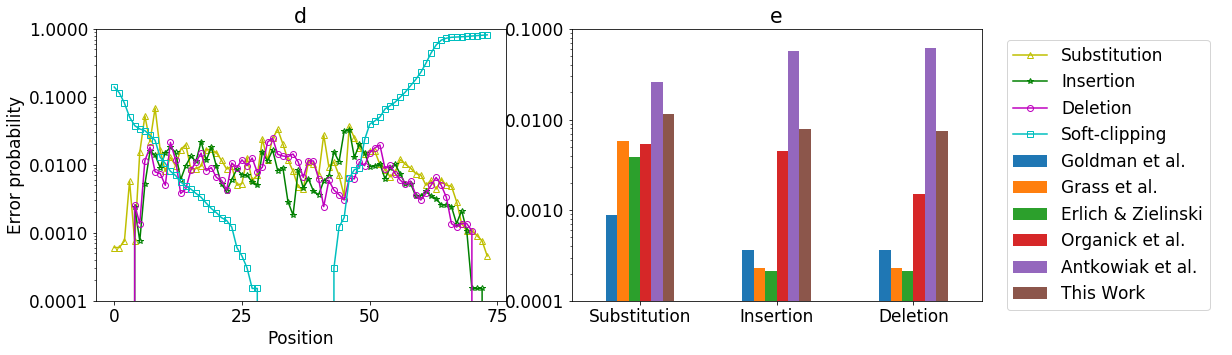

In [11]:
font = 17
plt.rcParams.update({'font.size': font})
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), gridspec_kw={'width_ratios': [2.5, 2.5, 1]})
axs[2].axis('off')

p1 = axs[0].plot(pos[0:74], mis_rate[0:74], 'y^-', markerfacecolor='none', label='Substitution')
p2 = axs[0].plot(pos[0:74], i_rate[0:74], 'g*-', markerfacecolor='none', label='Insertion')
p3 = axs[0].plot(pos[0:74], d_rate[0:74], 'mo-', markerfacecolor='none', label='Deletion')
p4 = axs[0].plot(pos[0:74], other_rate[0:74], 'cs-', markerfacecolor='none', label='Soft-clipping')

axs[0].set_xlabel('Position')
axs[0].set_ylabel('Error probability')
axs[0].set(xticks=(np.arange(0, 76, 25)))
axs[0].set_yscale('log') # some out of the figure, because error rate is 0, and log0 is infinity
axs[0].set(ylim=((0.0001, 1)))
axs[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
axs[0].yaxis.set_minor_formatter(mticker.NullFormatter())
axs[0].set_title('d')

Substitution = ['Substitution', 0.00088, 0.00585, 0.003870, 0.005400, 0.026000, 0.011411]
Insertion = ['Insertion', 0.00036, 0.000230, 0.000211, 0.004500, 0.057000, 0.007817]
Deletion = ['Deletion', 0.00036, 0.000230, 0.000211, 0.001500, 0.062000,0.007485]
data = [Substitution, Insertion, Deletion]
p5 =df=pd.DataFrame(data,columns=["Name", "Goldman et al.", "Grass et al.", "Erlich & Zielinski", "Organick et al.", "Antkowiak et al.", "This Work"])

df.plot(ax=axs[1], x="Name", y=["Goldman et al.", "Grass et al.", "Erlich & Zielinski", "Organick et al.", "Antkowiak et al.", "This Work"], kind="bar")
axs[1].set_xlabel('')
axs[1].tick_params(labelrotation=00)
axs[1].set_yscale('log')
axs[1].set(ylim=((0.0001, 0.1)))
axs[1].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
axs[1].yaxis.set_minor_formatter(mticker.NullFormatter())
axs[1].set_title('e')


axs[1].get_legend().remove()
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()

lgd = fig.legend(handles0+handles1, labels0+ labels1, loc='right', bbox_to_anchor=(0.84, 0.5), borderaxespad=0)


plt.savefig('/Users/yan/Desktop/eurecom_code/data/motif/error-rate.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

## 1. Comparison of errors in previous work

/Users/yan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


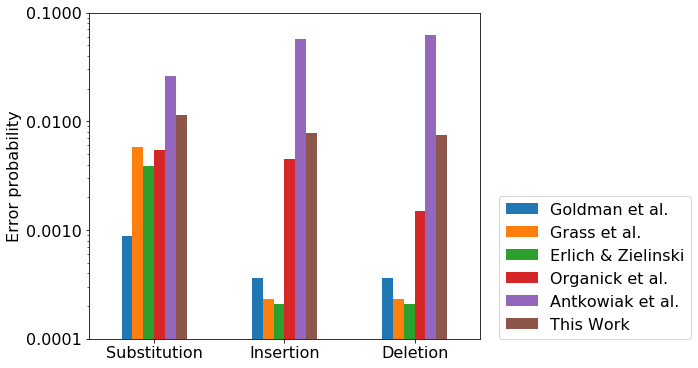

In [30]:
Substitution = ['Substitution', 0.00088, 0.00585, 0.003870, 0.005400, 0.026000, 0.011411]
Insertion = ['Insertion', 0.00036, 0.000230, 0.000211, 0.004500, 0.057000, 0.007817]
Deletion = ['Deletion', 0.00036, 0.000230, 0.000211, 0.001500, 0.062000,0.007485]

data = [Substitution, Insertion, Deletion]
df=pd.DataFrame(data,columns=["Name", "Goldman et al.", "Grass et al.", "Erlich & Zielinski", "Organick et al.", "Antkowiak et al.", "This Work"])

df.plot(x="Name", y=["Goldman et al.", "Grass et al.", "Erlich & Zielinski", "Organick et al.", "Antkowiak et al.", "This Work"], kind="bar",figsize=(7,6))
# plt.ylim((0, 0.07))


font = 16
plt.rcParams.update({'font.size': 16})

plt.xlabel('')
plt.ylabel('Error probability')
plt.xticks(rotation=00)

plt.yscale('log') 
plt.ylim((0.0001, 0.1))
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))

# ax.yaxis.set_major_formatter(mticker.ScalarFormatter('%.2f'))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())

plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0, prop={'size': font})
plt.savefig('/Users/yan/Desktop/eurecom_code/data/motif/cmp-other-log.pdf', bbox_inches='tight')

## 2. Number of oligos correctly reconstructed

/Users/yan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


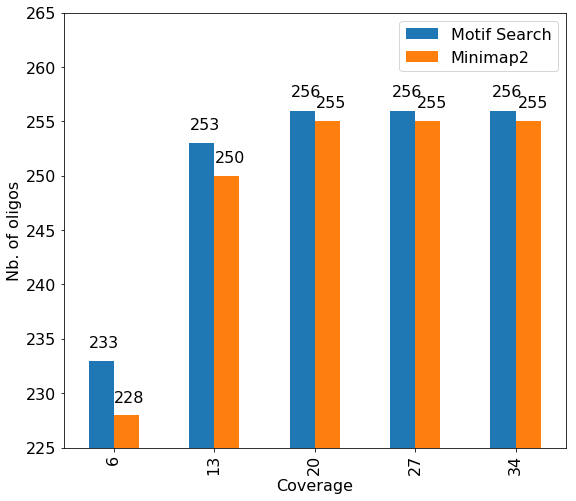

In [22]:
import pandas as pd 
import matplotlib.pyplot as plt 

data=[["6",233,228],
      ["13",253,250],
      ["20",256,255],
      ["27",256,255],
      ["34",256,255]
     ]

font = 16
plt.rcParams.update({'font.size': 16})

df=pd.DataFrame(data,columns=["Coverage","Motif Search","Minimap2"])
ax = df.plot(x="Coverage", y=["Motif Search","Minimap2"], kind="bar",figsize=(9,8))

ax.set_ylim(225, 265)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.ylabel('Nb. of oligos')
fig = ax.get_figure()
fig.savefig("/Users/yan/Desktop/eurecom_code/data/motif/boa-tp.pdf")

## 3. sequence cost

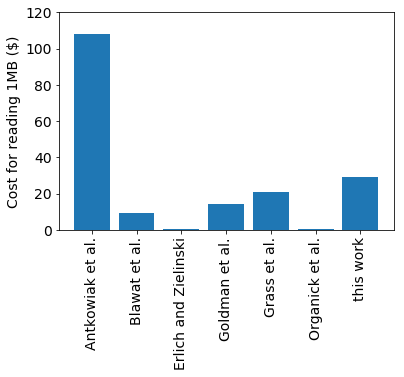

In [12]:
# name =["Goldman et al.", "Grass et al.", "Erlich & Zielinski", "Organick et al.", "Antkowiak et al.", "Blawat et al.", "This Work"]
# cost = [9, 16, 0.32, 0.22, 54, 7.5, 14.8]
name =["Antkowiak et al.", "this work", "Grass et al.", "Goldman et al.", "Blawat et al.", "Erlich and Zielinski", "Organick et al."]
cost = [108, 29, 21, 14, 9, 0.43, 0.30]

plt.rcParams.update({'font.size': 14})
plt.bar(name, cost)
plt.ylabel('Cost for reading 1MB ($)')
plt.xticks(rotation=90)
plt.ylim((0, 120))

plt.savefig('/Users/yan/Desktop/eurecom_code/data/motif/sequence-cost.pdf', bbox_inches='tight')
plt.show()


## 4. synthsis cost

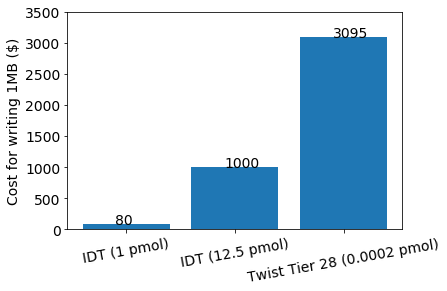

In [13]:
name =["Twist Tier 28 (0.0002 pmol)", "IDT (12.5 pmol)", "IDT (1 pmol)"]
cost = [3095, 1000, 80]

plt.rcParams.update({'font.size': 14})
plt.bar(name, cost)
plt.ylabel('Cost for writing 1MB ($)')
plt.xticks(rotation=10)
plt.ylim((0, 3500))

ax = plt.gca()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.3, p.get_height()))
    
plt.savefig('/Users/yan/Desktop/eurecom_code/data/motif/synthesis-cost.pdf', bbox_inches='tight')
plt.show()
